### Import the necessary modules.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Import the filtered dataset.

In [24]:
df = pd.read_csv('baseline_df.csv', index_col=0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391721 entries, 0 to 444132
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   WEATHER_CONDITION     391721 non-null  object 
 1   LIGHTING_CONDITION    391721 non-null  object 
 2   ROADWAY_SURFACE_COND  391719 non-null  object 
 3   DAMAGE                391719 non-null  object 
 4   CRASH_HOUR            391719 non-null  float64
 5   CRASH_DAY_OF_WEEK     391719 non-null  float64
 6   CRASH_MONTH           391719 non-null  float64
 7   MOST_SEVERE_INJURY    391224 non-null  object 
dtypes: float64(3), object(5)
memory usage: 26.9+ MB


# EDA.

### Explore the UNIQUE VALUES of each categorical column.

In [26]:
print("Unique values in the 'WEATHER_CONDITION' column:")
print(df['WEATHER_CONDITION'].value_counts())

print("\nUnique values in the 'LIGHTING_CONDITION' column:")
print(df['LIGHTING_CONDITION'].value_counts())

print("\nUnique values in the 'ROADWAY_SURFACE_COND' column:")
print(df['ROADWAY_SURFACE_COND'].value_counts())

print("\nUnique values in the 'DAMAGE' column:")
print(df['DAMAGE'].value_counts())

print("\nUnique values in the 'MOST_SEVERE_INJURY' column:")
print(df['MOST_SEVERE_INJURY'].value_counts())

Unique values in the 'WEATHER_CONDITION' column:
WEATHER_CONDITION
CLEAR                     307726
RAIN                       35638
UNKNOWN                    17971
SNOW                       15234
CLOUDY/OVERCAST            12284
OTHER                       1252
FOG/SMOKE/HAZE               746
SLEET/HAIL                   695
SEVERE CROSS WIND GATE        85
FREEZING RAIN/DRIZZLE         78
BLOWING SNOW                  12
Name: count, dtype: int64

Unique values in the 'LIGHTING_CONDITION' column:
LIGHTING_CONDITION
DAYLIGHT                  258086
DARKNESS, LIGHTED ROAD     80374
DARKNESS                   19256
UNKNOWN                    15400
DUSK                       11817
DAWN                        6786
DAYLIGH{                       2
Name: count, dtype: int64

Unique values in the 'ROADWAY_SURFACE_COND' column:
ROADWAY_SURFACE_COND
DRY                290363
WET                 55177
UNKNOWN             27060
SNOW OR SLUSH       15247
ICE                  2945
OTHER        

In [27]:
# Replace the incorrect 'LIGHTING_CONDITION' value with the correct value
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].replace('DAYLIGH{', 'DAYLIGHT')

# Verify the corrected value
print(df['LIGHTING_CONDITION'].unique())

['DAYLIGHT' 'UNKNOWN' 'DAWN' 'DARKNESS, LIGHTED ROAD' 'DARKNESS' 'DUSK']


In [28]:
# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Print the columns with null values
print(null_counts[null_counts > 0])

ROADWAY_SURFACE_COND      2
DAMAGE                    2
CRASH_HOUR                2
CRASH_DAY_OF_WEEK         2
CRASH_MONTH               2
MOST_SEVERE_INJURY      497
dtype: int64


In [29]:
# Drop rows with null values
df = df.dropna()

# Print the updated DataFrame shape
print(df.shape)


(391224, 8)


### Make countplots for the UNIQUE values of each categorical column.

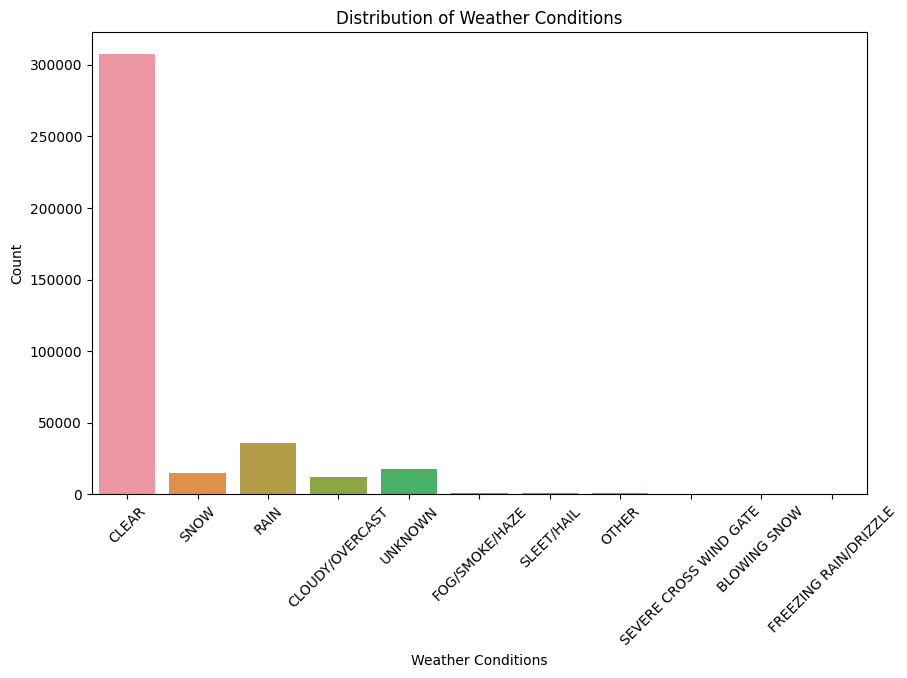

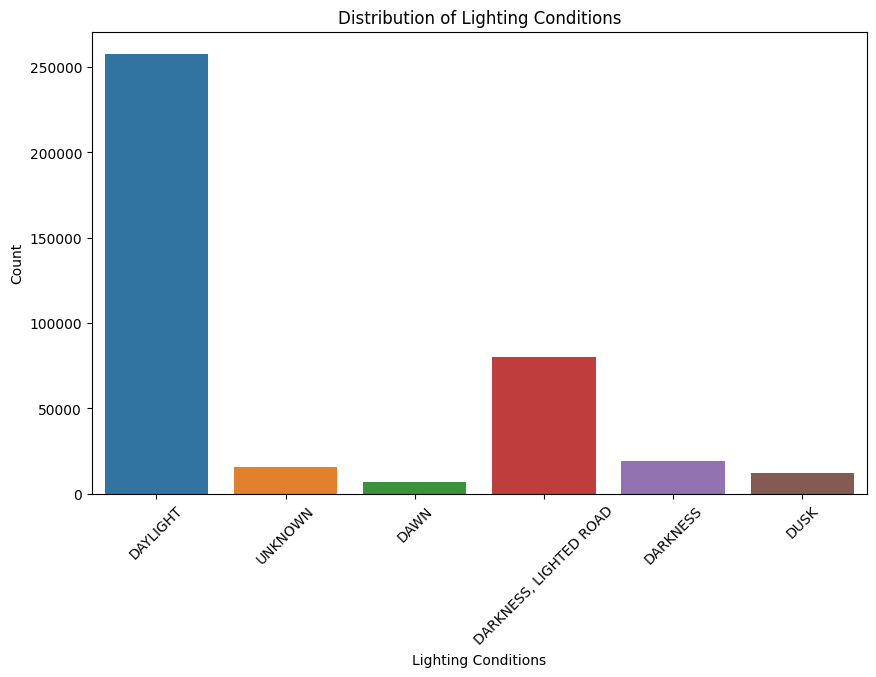

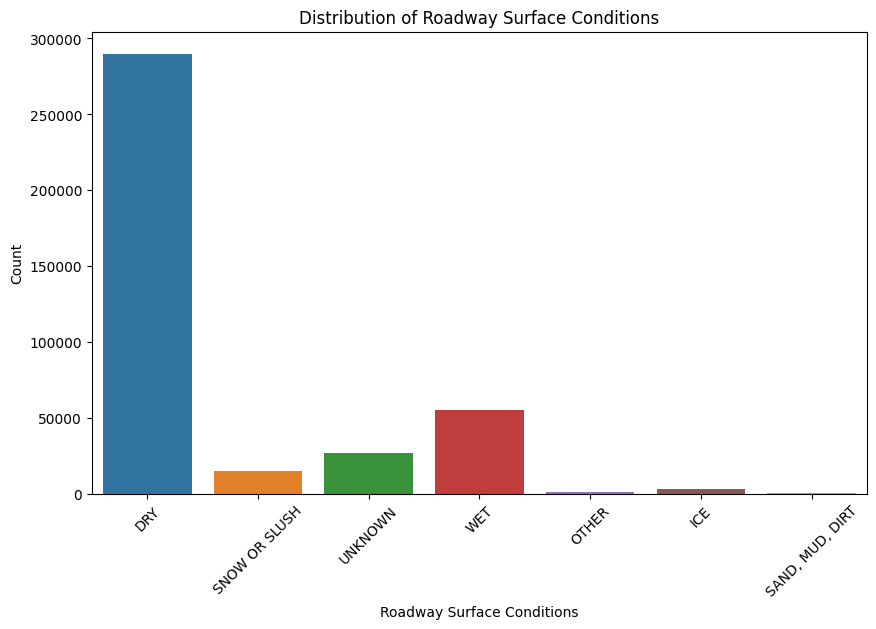

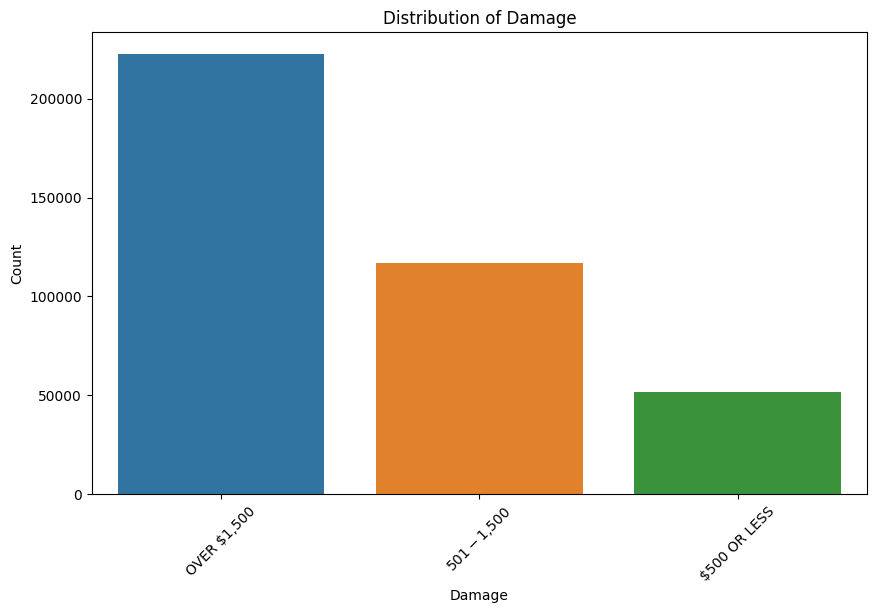

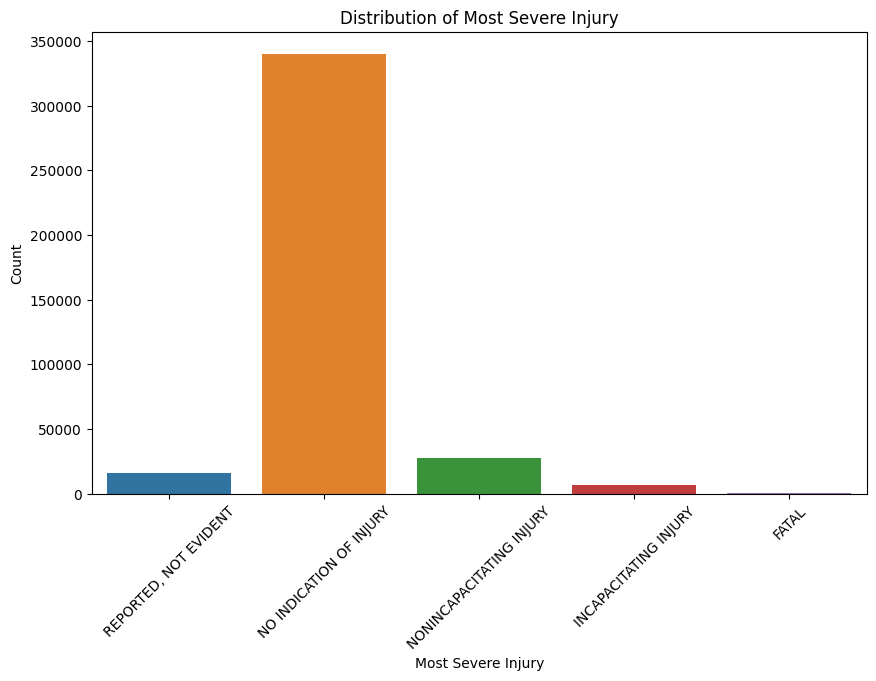

In [10]:
# Countplot for 'WEATHER_CONDITION'
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'WEATHER_CONDITION', dodge = True)
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'LIGHTING_CONDITION' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'LIGHTING_CONDITION', dodge = True)
plt.title('Distribution of Lighting Conditions')
plt.xlabel('Lighting Conditions')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'ROADWAY_SURFACE_COND' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'ROADWAY_SURFACE_COND', dodge = True)
plt.title('Distribution of Roadway Surface Conditions')
plt.xlabel('Roadway Surface Conditions')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'DAMAGE' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'DAMAGE', dodge = True)
plt.title('Distribution of Damage')
plt.xlabel('Damage')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'MOST_SEVERE_INJURY' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'MOST_SEVERE_INJURY', dodge = True)
plt.title('Distribution of Most Severe Injury')
plt.xlabel('Most Severe Injury')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

The groupby() function below indicates the exact numeric distribution for the graph above depicting categories for the MOST_SEVERE_INJURY column.

In [30]:
grouped = df.groupby('MOST_SEVERE_INJURY')
count_per_group = grouped.size()
print(count_per_group)

MOST_SEVERE_INJURY
FATAL                          346
INCAPACITATING INJURY         6624
NO INDICATION OF INJURY     339934
NONINCAPACITATING INJURY     28059
REPORTED, NOT EVIDENT        16261
dtype: int64


### Make heatmaps of cross-tabulation between every possible 'MOST_SEVERE_INJURY' column pair.

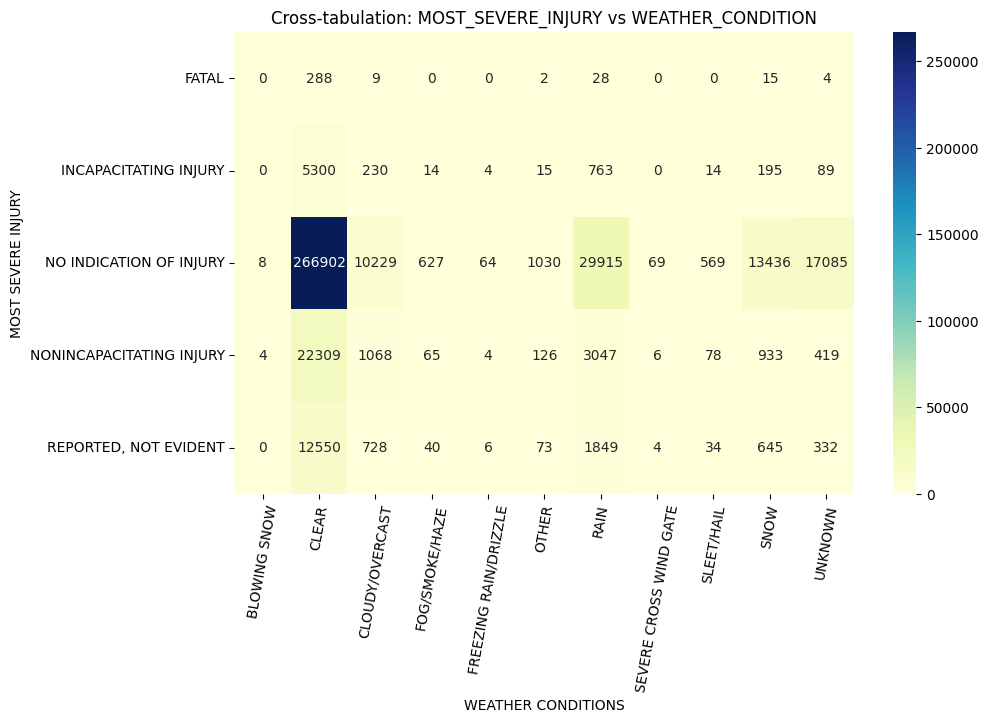

In [12]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'WEATHER_CONDITION'
cross_tab_severe_weather = pd.crosstab(df['MOST_SEVERE_INJURY'], df['WEATHER_CONDITION'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_weather, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs WEATHER_CONDITION")
plt.xlabel("WEATHER CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()


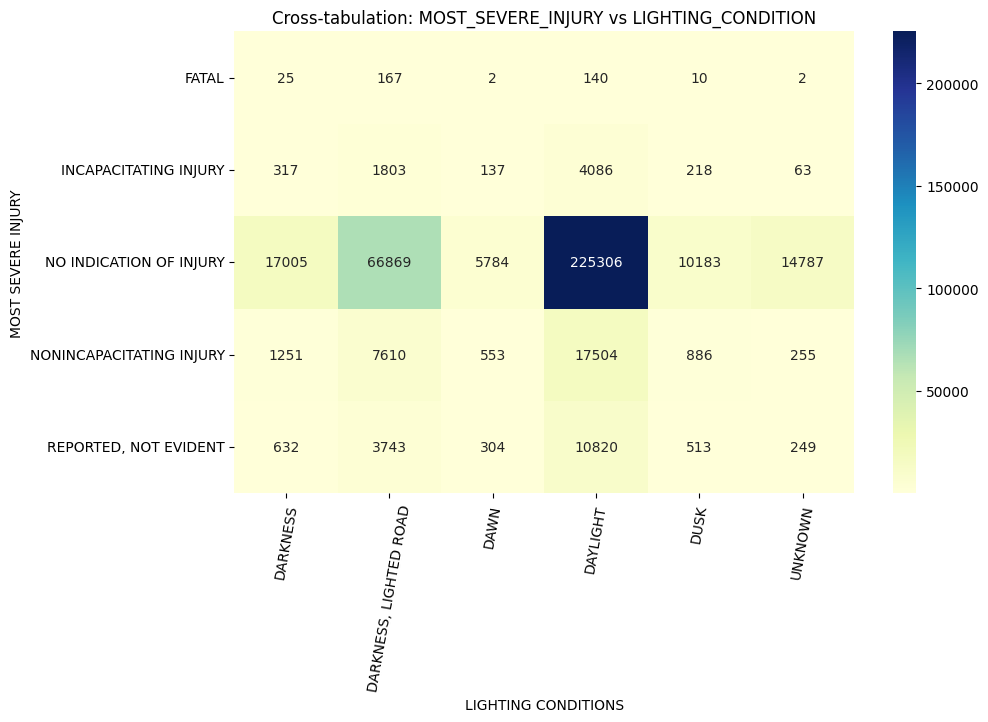

In [13]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'LIGHTING_CONDITION'
cross_tab_severe_lighting = pd.crosstab(df['MOST_SEVERE_INJURY'], df['LIGHTING_CONDITION'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_lighting, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs LIGHTING_CONDITION")
plt.xlabel("LIGHTING CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

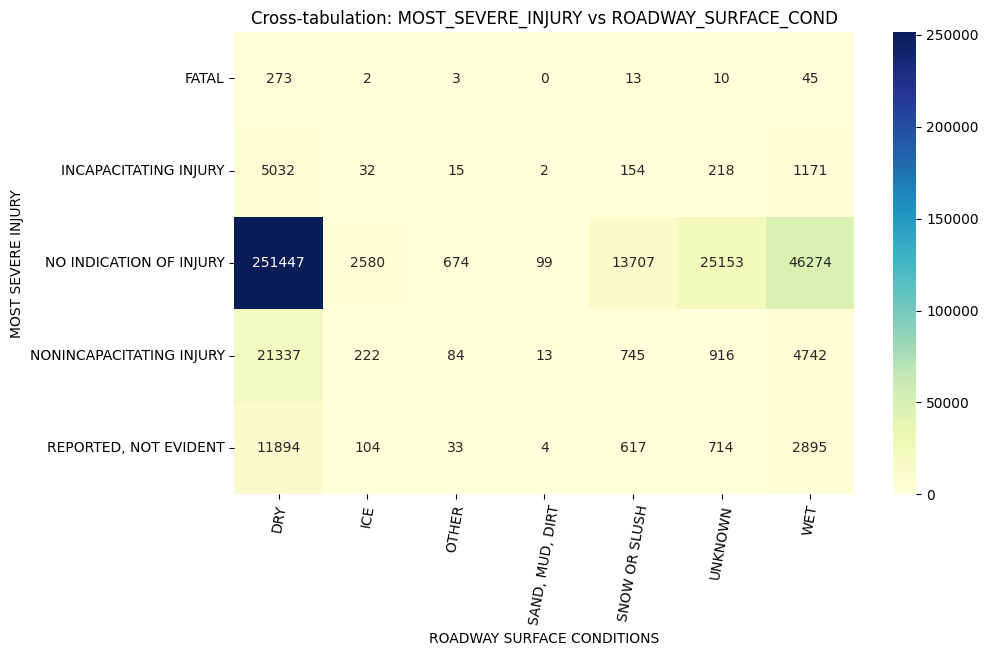

In [14]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'ROADWAY_SURFACE_COND'
cross_tab_severe_roadway = pd.crosstab(df['MOST_SEVERE_INJURY'], df['ROADWAY_SURFACE_COND'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_roadway, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs ROADWAY_SURFACE_COND")
plt.xlabel("ROADWAY SURFACE CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

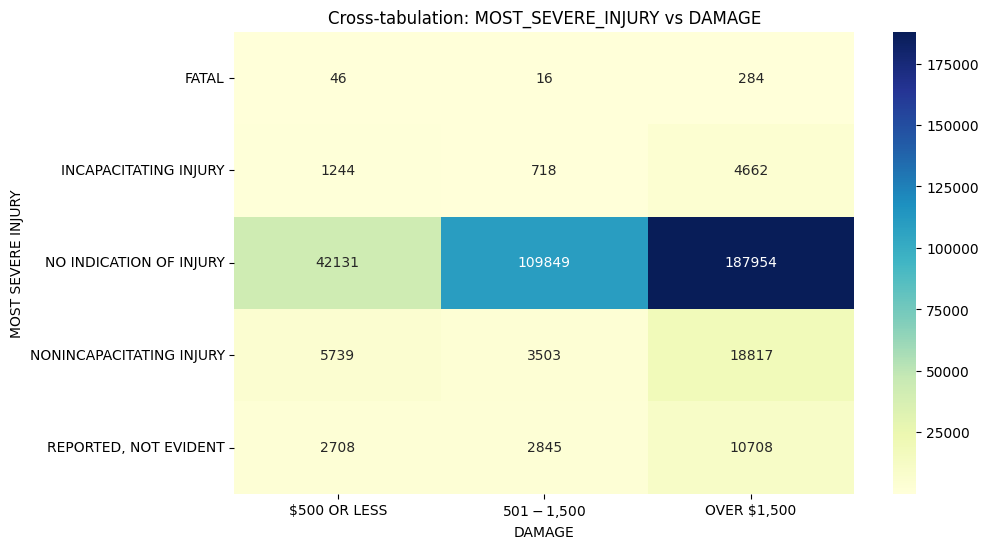

In [15]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'DAMAGE'
cross_tab_severe_damage = pd.crosstab(df['MOST_SEVERE_INJURY'], df['DAMAGE'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_damage, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs DAMAGE")
plt.xlabel("DAMAGE")
plt.ylabel("MOST SEVERE INJURY")
plt.show()

# PREPROCESSING

### PERFORM ORDINAL ENCODING FOR SUITABLE CATEGORICAL COLUMNS.

In [17]:
from sklearn.preprocessing import OrdinalEncoder

# Define the desired order of categories
category_order = ['NO INDICATION OF INJURY', 'REPORTED, NOT EVIDENT', 'NONINCAPACITATING INJURY',
                  'INCAPACITATING INJURY', 'FATAL']

# Create an instance of the OrdinalEncoder with specified categories
ordinal_encoder = OrdinalEncoder(categories = [category_order])

# Perform ordinal encoding on the 'MOST_SEVERE_INJURY' column
encoded_values = ordinal_encoder.fit_transform(df[['MOST_SEVERE_INJURY']]) # <-- 

# Replace the original column with the encoded values
df['MOST_SEVERE_INJURY'] = encoded_values

# Print the updated DataFrame
print(df.head())

ValueError: could not convert string to float: 'NO INDICATION OF INJURY'

In [31]:
# Define the desired order of categories
category_order = ['$500 OR LESS', '$501 - $1,500', 'OVER $1,500']

# Create an instance of the OrdinalEncoder with specified categories
ordinal_encoder = OrdinalEncoder(categories=[category_order])

# Perform ordinal encoding on the 'DAMAGE' column
encoded_values = ordinal_encoder.fit_transform(df[['DAMAGE']]) # <--

# Replace the original column with the encoded values
df['DAMAGE'] = encoded_values

# Print the updated DataFrame
print(df.head())


  WEATHER_CONDITION LIGHTING_CONDITION ROADWAY_SURFACE_COND  DAMAGE   
0             CLEAR           DAYLIGHT                  DRY     2.0  \
1             CLEAR           DAYLIGHT                  DRY     2.0   
2             CLEAR           DAYLIGHT                  DRY     2.0   
3             CLEAR           DAYLIGHT                  DRY     2.0   
4             CLEAR            UNKNOWN                  DRY     2.0   

   CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH       MOST_SEVERE_INJURY  
0        14.0                2.0          3.0    REPORTED, NOT EVIDENT  
1        14.0                2.0          3.0    REPORTED, NOT EVIDENT  
2         8.0                4.0          9.0  NO INDICATION OF INJURY  
3         8.0                4.0          9.0  NO INDICATION OF INJURY  
4        17.0                1.0          6.0  NO INDICATION OF INJURY  


### PERFORM ONE-HOT ENCODING FOR SUITABLE CATEGORICAL COLUMNS.

In [45]:
# Perform one-hot encoding on the 'WEATHER_CONDITION' column
encoded_df = pd.get_dummies(df['WEATHER_CONDITION'], prefix = 'WEATHER') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis = 1)

# Remove the original 'WEATHER_CONDITION' column
df.drop('WEATHER_CONDITION', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())

   Unnamed: 0 LIGHTING_CONDITION ROADWAY_SURFACE_COND  DAMAGE  CRASH_HOUR   
0           0           DAYLIGHT                  DRY     2.0        14.0  \
1           1           DAYLIGHT                  DRY     2.0        14.0   
2           2           DAYLIGHT                  DRY     2.0         8.0   
3           3           DAYLIGHT                  DRY     2.0         8.0   
4           4            UNKNOWN                  DRY     2.0        17.0   

   CRASH_DAY_OF_WEEK  CRASH_MONTH       MOST_SEVERE_INJURY   
0                2.0          3.0    REPORTED, NOT EVIDENT  \
1                2.0          3.0    REPORTED, NOT EVIDENT   
2                4.0          9.0  NO INDICATION OF INJURY   
3                4.0          9.0  NO INDICATION OF INJURY   
4                1.0          6.0  NO INDICATION OF INJURY   

   WEATHER_BLOWING SNOW  WEATHER_CLEAR  WEATHER_CLOUDY/OVERCAST   
0                 False           True                    False  \
1                 False       

In [17]:
# Perform one-hot encoding on the 'LIGHTING_CONDITION' column
encoded_df = pd.get_dummies(df['LIGHTING_CONDITION'], prefix='LIGHTING') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Remove the original 'LIGHTING_CONDITION' column
df.drop('LIGHTING_CONDITION', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())

   Unnamed: 0 ROADWAY_SURFACE_COND  DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK   
0           0                  DRY     2.0        14.0                2.0  \
1           1                  DRY     2.0        14.0                2.0   
2           2                  DRY     2.0         8.0                4.0   
3           3                  DRY     2.0         8.0                4.0   
4           4                  DRY     2.0        17.0                1.0   

   CRASH_MONTH  MOST_SEVERE_INJURY  WEATHER_BLOWING SNOW  WEATHER_CLEAR   
0          3.0                 1.0                 False           True  \
1          3.0                 1.0                 False           True   
2          9.0                 0.0                 False           True   
3          9.0                 0.0                 False           True   
4          6.0                 0.0                 False           True   

   WEATHER_CLOUDY/OVERCAST  ...  WEATHER_SEVERE CROSS WIND GATE   
0                  

In [18]:
# Perform one-hot encoding on the 'ROADWAY_SURFACE_COND' column
encoded_df = pd.get_dummies(df['ROADWAY_SURFACE_COND'], prefix='ROADWAY') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Remove the original 'ROADWAY_SURFACE_COND' column
df.drop('ROADWAY_SURFACE_COND', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())


   Unnamed: 0  DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH   
0           0     2.0        14.0                2.0          3.0  \
1           1     2.0        14.0                2.0          3.0   
2           2     2.0         8.0                4.0          9.0   
3           3     2.0         8.0                4.0          9.0   
4           4     2.0        17.0                1.0          6.0   

   MOST_SEVERE_INJURY  WEATHER_BLOWING SNOW  WEATHER_CLEAR   
0                 1.0                 False           True  \
1                 1.0                 False           True   
2                 0.0                 False           True   
3                 0.0                 False           True   
4                 0.0                 False           True   

   WEATHER_CLOUDY/OVERCAST  WEATHER_FOG/SMOKE/HAZE  ...  LIGHTING_DAYLIGHT   
0                    False                   False  ...               True  \
1                    False                   False  ... 

In [20]:
df.head()

,Unnamed: 0,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,DAMAGE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,MOST_SEVERE_INJURY
0,0,CLEAR,DAYLIGHT,DRY,2.0,14.0,2.0,3.0,1.0
1,1,CLEAR,DAYLIGHT,DRY,2.0,14.0,2.0,3.0,1.0
2,2,CLEAR,DAYLIGHT,DRY,2.0,8.0,4.0,9.0,0.0
3,3,CLEAR,DAYLIGHT,DRY,2.0,8.0,4.0,9.0,0.0
4,4,CLEAR,UNKNOWN,DRY,2.0,17.0,1.0,6.0,0.0


### SPLIT DATA INTO TRAIN/TEST SETS.

In [49]:
# Split the features and target variable
X = df.drop(['MOST_SEVERE_INJURY', 'DAMAGE'], axis=1)  # Features
y = df['MOST_SEVERE_INJURY']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [51]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train).toarray(), columns=encoder.get_feature_names_out())
X_test_encoded = pd.DataFrame(encoder.transform(X_test).toarray(), columns=encoder.get_feature_names_out())


### PERFORM SMOTE TO ADDRESS CLASS IMBALANCE.

In [52]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

### APPLY A DUMMY CLASSIFIER AS THE BASELINE MODEL.

In [53]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create an instance of the Dummy Classifier with the desired strategy
dummy_clf = DummyClassifier(strategy = 'most_frequent')

# Fit the Dummy Classifier to the training data
dummy_clf.fit(X_train_encoded, y_train)

# Generate predictions using the Dummy Classifier
y_pred = dummy_clf.predict(X_test_encoded)

# Evaluate the performance of the Dummy Classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8688995296844114
Precision: 0.8688995296844114
Recall: 0.8688995296844114
F1-Score: 0.8688995296844114


### APPLY A DECISION TREE MODEL.

In [54]:
from sklearn.tree import DecisionTreeClassifier

# Create an instance of the DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

# Train the model on the oversampled training data
tree.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = tree.predict(X_test_encoded)

# Evaluate the model's performance using classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.4755469974780179
Precision: 0.8008440908337718
Recall: 0.4755469974780179
F1-Score: 0.5766870299781465


In [55]:
feature_imp = {}
for fi, feature in zip(tree.feature_importances_, tree.feature_names_in_):
    feature_imp[feature] = fi

feature_imp


{'WEATHER_CONDITION_CLEAR': 0.03204691399795401,
 'WEATHER_CONDITION_CLOUDY/OVERCAST': 0.015114237009298901,
 'WEATHER_CONDITION_FOG/SMOKE/HAZE': 0.0013420849179478747,
 'WEATHER_CONDITION_FREEZING RAIN/DRIZZLE': 0.00029489999957303827,
 'WEATHER_CONDITION_OTHER': 0.0020109666660499004,
 'WEATHER_CONDITION_RAIN': 0.017791710491574166,
 'WEATHER_CONDITION_SEVERE CROSS WIND GATE': 9.092473713878314e-05,
 'WEATHER_CONDITION_SLEET/HAIL': 0.0010326205815484734,
 'WEATHER_CONDITION_SNOW': 0.00824123947095123,
 'WEATHER_CONDITION_UNKNOWN': 0.0029491241125394725,
 'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD': 0.04051474487510721,
 'LIGHTING_CONDITION_DAWN': 0.005166637049841205,
 'LIGHTING_CONDITION_DAYLIGHT': 0.013841057246115491,
 'LIGHTING_CONDITION_DUSK': 0.008605054416670322,
 'LIGHTING_CONDITION_UNKNOWN': 0.003957913413824951,
 'ROADWAY_SURFACE_COND_ICE': 0.004149979098055203,
 'ROADWAY_SURFACE_COND_OTHER': 0.0021188687881872146,
 'ROADWAY_SURFACE_COND_SAND, MUD, DIRT': 0.0002504975288896

### TUNE THE DECISION TREE HYPERPARAMETERS USING GRID SEARCH CROSS-VALIDATION.

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create an instance of the Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the performance of the best model on the test set
y_pred = best_model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.

# Print the evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

KeyboardInterrupt: 

### APPLY OPTIMAL HYPERPARAMETERS TO FINAL MODEL.

In [24]:
# Create the final model with the optimized hyperparameters
final_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split = 2)

# Train the final model on the entire training dataset
final_model.fit(X_train, y_train)

# Evaluate the performance of the final model on the test set
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8689250903142254
Precision: 0.788260421009006
Recall: 0.8689250903142254
F1-Score: 0.80802613073881


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
